# Have a look of Image and Label

In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os

In [2]:
root_train_imgs = "../__HW7_DATA/rgb_images/"
root_train_mask = "../__HW7_DATA/semantic_annotations/gtLabels/"

First 5 train imgs are ['00000_FV.png', '00001_FV.png', '00002_FV.png', '00003_FV.png', '00004_FV.png']
(966, 1280, 3)


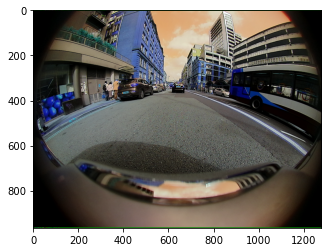

First 5 train mask are ['00000_FV.png', '00001_FV.png', '00002_FV.png', '00003_FV.png', '00004_FV.png']


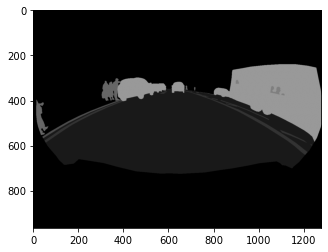

In [3]:
img_num = 2

train_imgs = os.listdir(root_train_imgs)
print(f"First 5 train imgs are {train_imgs[:5]}")
img = cv.imread(root_train_imgs + train_imgs[img_num])
print(img.shape)
plt.imshow(img)
plt.show()

train_mask = os.listdir(root_train_mask)
print(f"First 5 train mask are {train_mask[:5]}")
mask = cv.imread(root_train_mask + train_mask[img_num])
mask_draw = mask/10
plt.imshow(mask_draw)
plt.show()

# Build Custom Dataset Class

In [4]:
import cv2 as cv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class RoadDataset(Dataset):
    
    def __init__(self, width, height, path_to_imgs, path_to_mask, transform = None):
        
        self.height = height
        self.width = width
        self.path_to_img = path_to_imgs
        self.path_to_mask= path_to_mask
        
        self.train_imgs = os.listdir(path_to_imgs)
        self.train_mask = os.listdir(path_to_mask)
        
        self.length = len(self.train_imgs)
        self.transform = transform
        
    def __getitem__(self, index):
        
        img = cv.imread(self.path_to_img + self.train_imgs[index])
        msk = cv.imread(self.path_to_mask + self.train_mask[index])
        
        img_resize = cv.resize(img, (self.width, self.height))
        msk_resize = cv.resize(msk, (self.width, self.height))
        
        if self.transform:
            img_tensor = self.transform(img_resize)
        
        return (img_tensor, msk_resize)
        
        
    def __len__(self):
        return self.length
    
trans = transforms.Compose([
    transforms.ToTensor(),
])

width = 192
height = 192

Train_Dataset = RoadDataset(width, height, root_train_imgs, root_train_mask, trans)

batch_size = 3

Train_Dataloader = DataLoader(Train_Dataset, batch_size = batch_size, shuffle = True, num_workers = 0)

# See Model Summary

In [5]:
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = pytorch_unet.UNet(10)
#model = model.to(device)

#summary(model, input_size = (3, 192, 192))

# Train UNet

In [8]:
from collections import defaultdict
import torch
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
                    
            model.train()

        metrics = defaultdict(float)
        epoch_samples = 0
            
        for inputs, labels in Train_Dataloader:
            inputs, labels = inputs.to(device), labels.to(device)             

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = calc_loss(outputs, labels, metrics)

            loss.backward()
            
            optimizer.step()
            
            epoch_samples += inputs.size(0)
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            
            scheduler.step()


        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 10

model = pytorch_unet.UNet(num_class).to(device)

# observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr = 1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 25, gamma = 0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs = 30)

cuda:0
Epoch 0/29
----------
LR 0.0001


RuntimeError: CUDA out of memory. Tried to allocate 82.00 MiB (GPU 0; 2.00 GiB total capacity; 417.78 MiB already allocated; 22.81 MiB free; 454.00 MiB reserved in total by PyTorch)